## This program takes in the stock prices of Apple Inc. from Jan 1st 2010 to Oct 31st 2019, and then tries to predict the trend in the stock proces for the next two months, i.e., Nov 2019 and Dec 2019.

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#importing training set
os.chdir(r"D:\AAPL")
train = pd.read_csv("Apple_Stock_Prices_Train.csv", sep = ",", encoding = "ISO-8859-1")

### Part 1. Data Preprocessing

We are concerned with only the **Open** column here as we will use that to predict all the **Open** prices for the two months. So lets separate out those values.

In [5]:
#selecting Open column and creating numpy array
training_set = train.iloc[:, 1:2].values
training_set

array([[ 30.49    ],
       [ 30.657143],
       [ 30.625713],
       ...,
       [247.419998],
       [248.970001],
       [244.759995]])

In [7]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.01358342],
       [0.01433805],
       [0.01419615],
       ...,
       [0.99300188],
       [1.        ],
       [0.98099222]])

In [8]:
training_set_scaled.shape

(2474, 1)

In [9]:
#create number of time steps to tell the RNN what to remember
#creating a data structure with 120 timesteps and 1 output
#thus the RNN will predict the stock price at time t by learning the trend from past 120 inputs, or past 6 months
X_train = []
y_train = []
#lower bound is 120 because it can only start from the 121st value to have 120 previous inputs
#upper bound is 2474 becuase this is excluded, 2475 is the index number of this last value
for i in range(120, 2474):
    X_train.append(training_set_scaled[i-120 : i, 0]) #0 for column index
    y_train.append(training_set_scaled[i, 0])
#convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train

array([[0.01358342, 0.01433805, 0.01419615, ..., 0.05146348, 0.05302435,
        0.0507153 ],
       [0.01433805, 0.01419615, 0.01249984, ..., 0.05302435, 0.0507153 ,
        0.05010901],
       [0.01419615, 0.01249984, 0.01156461, ..., 0.0507153 , 0.05010901,
        0.0480902 ],
       ...,
       [0.78748336, 0.780711  , 0.7672566 , ..., 0.96898262, 0.97986349,
        0.97376841],
       [0.780711  , 0.7672566 , 0.72341691, ..., 0.97986349, 0.97376841,
        0.99300188],
       [0.7672566 , 0.72341691, 0.71754752, ..., 0.97376841, 0.99300188,
        1.        ]])

First list corresponds to i being 121st value, and previous 120 values.

In [11]:
y_train

array([0.05010901, 0.0480902 , 0.04627779, ..., 0.99300188, 1.        ,
       0.98099222])

Here, each entry corredponds to 121st, 122nd, ... values.

In [12]:
#reshaping to add more dimensionality
#3 parameters acc to keras docu: batch_size (how many stock prices), timesteps, input_dim
#1 indicator here
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
X_train

array([[[0.01358342],
        [0.01433805],
        [0.01419615],
        ...,
        [0.05146348],
        [0.05302435],
        [0.0507153 ]],

       [[0.01433805],
        [0.01419615],
        [0.01249984],
        ...,
        [0.05302435],
        [0.0507153 ],
        [0.05010901]],

       [[0.01419615],
        [0.01249984],
        [0.01156461],
        ...,
        [0.0507153 ],
        [0.05010901],
        [0.0480902 ]],

       ...,

       [[0.78748336],
        [0.780711  ],
        [0.7672566 ],
        ...,
        [0.96898262],
        [0.97986349],
        [0.97376841]],

       [[0.780711  ],
        [0.7672566 ],
        [0.72341691],
        ...,
        [0.97986349],
        [0.97376841],
        [0.99300188]],

       [[0.7672566 ],
        [0.72341691],
        [0.71754752],
        ...,
        [0.97376841],
        [0.99300188],
        [1.        ]]])

In [15]:
X_train.shape

(2354, 120, 1)

### Part 2. Building the RNN

In [14]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [24]:
#Initializing the RNN
regressor = Sequential()

In [25]:
#adding 1st LSTM layer and some Dropout regularization (to avoid overfitting)
regressor.add(LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2)) #20% will be dropped, 16 will be dropped

In [26]:
#adding 2nd LSTM layer and some dropout regularization
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(rate = 0.2)) #20% will be dropped, 10 will be dropped

In [27]:
#adding 3rd LSTM layer and some dropout regularization
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(rate = 0.2)) #20% will be dropped, 10 will be dropped

In [28]:
#adding 4th LSTM layer and some dropout regularization
#return sequences is False because no more layer after this, False by default
regressor.add(LSTM(units = 80))
regressor.add(Dropout(rate = 0.2)) #20% will be dropped, 10 will be dropped

In [29]:
#adding output layer
regressor.add(Dense(units = 1))

In [30]:
#compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

In [31]:
#fitting the RNN to the training set
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
2354/2354 [==============================] - 36s 15ms/step - loss: 0.0121
Epoch 2/100
2354/2354 [==============================] - 34s 14ms/step - loss: 0.0027
Epoch 3/100
2354/2354 [==============================] - 34s 14ms/step - loss: 0.0021
Epoch 4/100
2354/2354 [==============================] - 34s 14ms/step - loss: 0.0022
Epoch 5/100
2354/2354 [==============================] - 34s 14ms/step - loss: 0.0021
Epoch 6/100
2354/2354 [==============================] - 34s 14ms/step - loss: 0.0018
Epoch 7/100
2354/2354 [==============================] - 37s 16ms/step - loss: 0.0016
Epoch 8/100
2354/2354 [==============================] - 40s 17ms/step - loss: 0.0017
Epoch 9/100
2354/2354 [==============================] - 39s 17ms/step - loss: 0.0021
Epoch 10/100
2354/2354 [==============================] - 1102s 468ms/step - loss: 0.0016
Epoch 11/100
2354/2354 [==============================] - 40s 17ms/step - loss: 0.0014
Epoch 12/100
2354/2354 [=========================

Initially I started out with 200 epochs, but then I saw that the losses were getting converged fairly early. So I reduced my number of epochs to 100. Now, loss converges at almost 0.05%, which is pretty good.

### Part 3. Making the predictions and visualizing the results

In [32]:
#getting the real stock price of Nov 2019 and Dec 2019
test = pd.read_csv("Apple_Stock_Prices_Test.csv", sep = ",", encoding = "ISO-8859-1")
#getting the numpy array
real_stock_price = test.iloc[:, 1:2].values
real_stock_price

array([[249.539993],
       [257.329987],
       [257.049988],
       [256.769989],
       [258.73999 ],
       [258.690002],
       [258.299988],
       [261.549988],
       [261.130005],
       [263.75    ],
       [263.679993],
       [265.799988],
       [267.899994],
       [265.540009],
       [263.690002],
       [262.589996],
       [262.709991],
       [266.940002],
       [265.579987],
       [266.600006],
       [267.269989],
       [258.309998],
       [261.070007],
       [263.790009],
       [267.480011],
       [270.      ],
       [268.600006],
       [268.809998],
       [267.779999],
       [271.459991],
       [277.      ],
       [279.570007],
       [279.799988],
       [279.5     ],
       [282.230011],
       [280.529999],
       [284.690002],
       [284.820007],
       [291.119995],
       [289.459991]])

In [33]:
#getting the predicted stock price of Jan 2017

#concatenate
dataset_total = pd.concat((train["Open"], test["Open"]), axis = 0) #0 for vertical axis

#get 120 previous stock prices as inputs for present financial day
inputs = dataset_total[len(dataset_total) - len(test) - 120 :].values

#simple reshape to get the right shape
inputs = inputs.reshape(-1, 1)

#scaling the inputs
inputs = sc.transform(inputs)

#creating number of time steps (special structure)
X_test = [] #inputs
for i in range(120, 160): #coz 40 financial days
    X_test.append(inputs[i-120 : i, 0]) #0 for column index
#convert lists to numpy arrays
X_test = np.array(X_test)

#obtain the right 3d format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#prediction
predicted_stock_price = regressor.predict(X_test)

#inverse the scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [35]:
predicted_stock_price.shape

(40, 1)

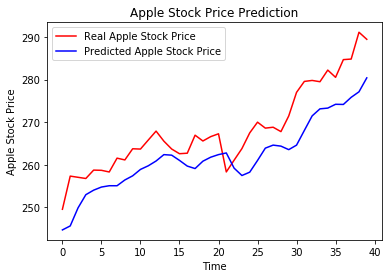

In [36]:
#visualizing the results
plt.plot(real_stock_price, color = "red", label = "Real Apple Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Apple Stock Price")
plt.title("Apple Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Apple Stock Price")
plt.legend()
plt.show()

Now we know that in real life, stock prices often have certain jumps in both direction, which are caused by unpredictable events or news, so in reality future stock prices cannot really be predicted. This model however, aims to predict trends in future stock prices. That's why we see a lag when it comes to the actual values. But the trends of these two have been fairly correctly predicted.